
--- Debug Info for 2023-01-02 ---
Min Previsto: 2.6848707, Max Previsto: 8.857007, Média Previsto: 5.072582798901099
Tipo Min Previsto: <class 'float'>
Debug: Previsão mínima (2.6848707) não é < -1000 ou é None/Inválida. Prosseguindo com a estratégia...
Diagnóstico da estratégia: {'Previsões Razoáveis': True, 'Estratégia Usada': 'Sem transações', 'Total de Transações': 0, 'Retorno (%)': 0.0, 'Min Previsto': 2.6848707, 'Max Previsto': 8.857007, 'Média Previsto': 5.072582798901099}

--- Debug Info for 2023-01-03 ---
Min Previsto: 0.9622173, Max Previsto: 4.2340965, Média Previsto: 2.349524097520661
Tipo Min Previsto: <class 'float'>
Debug: Previsão mínima (0.9622173) não é < -1000 ou é None/Inválida. Prosseguindo com a estratégia...
Diagnóstico da estratégia: {'Previsões Razoáveis': True, 'Estratégia Usada': 'Sem transações', 'Total de Transações': 0, 'Retorno (%)': 0.0, 'Min Previsto': 0.9622173, 'Max Previsto': 4.2340965, 'Média Previsto': 2.349524097520661}

--- Debug Info for 2023-0

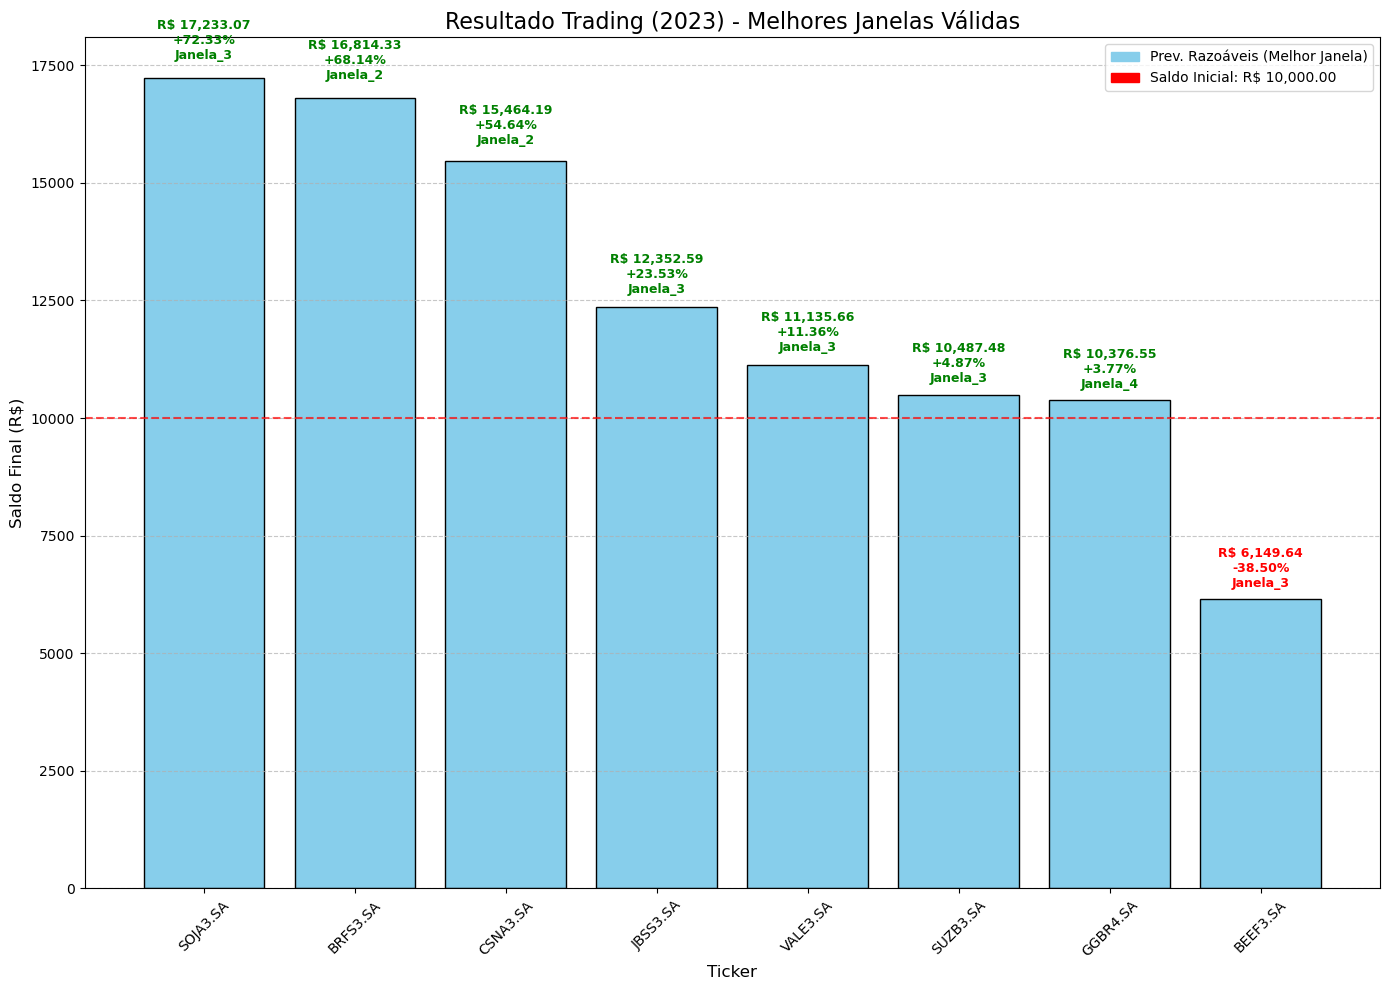


--- Execução Concluída ---


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Importar mpatches

# Diretório onde estão os arquivos de previsões
input_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicro"

# Diretório onde os resultados serão salvos
output_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroMicroResultados"
os.makedirs(output_dir, exist_ok=True)

# Diretório para salvar as transações
transactions_dir = os.path.join(output_dir, "Transacoes")
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
# Adicionado PETR4.SA de volta para teste completo, se necessário
tickers = ["BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", "SUZB3.SA", "GGBR4.SA", "CSNA3.SA"]

# Lista de janelas
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

# Estratégia "All-In" usando apenas previsões originais
def estrategia_all_in(dados_brutos, saldo_inicial):
    # Converter colunas para valores numéricos sem substituir as previsões
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados['Preço Previsto'] = pd.to_numeric(dados['Preço Previsto'], errors='coerce')

    # Verificar se as previsões estão dentro de um intervalo razoável, apenas para diagnóstico
    previsoes = dados['Preço Previsto'].dropna()
    min_previsto = previsoes.min() if len(previsoes) > 0 else None
    max_previsto = previsoes.max() if len(previsoes) > 0 else None
    media_previsoes = previsoes.mean() if len(previsoes) > 0 else None

    # Imprimir informações sobre as previsões (PARA DEBUG)
    identifier = dados_brutos['Data'].iloc[0] if not dados_brutos.empty and 'Data' in dados_brutos.columns else "Unknown"
    print(f"\n--- Debug Info for {identifier} ---")
    print(f"Min Previsto: {min_previsto}, Max Previsto: {max_previsto}, Média Previsto: {media_previsoes}")
    print(f"Tipo Min Previsto: {type(min_previsto)}")

    # VERIFICAR SE A PREVISÃO MÍNIMA É EXTREMAMENTE NEGATIVA
    is_extremely_negative = False
    if min_previsto is not None and isinstance(min_previsto, (int, float)) and min_previsto < -1000:
        is_extremely_negative = True
        print(f"!!! DEBUG: Previsão mínima ({min_previsto}) é < -1000. Marcado para bloquear transações. !!!")

    # Se marcado como extremamente negativo, retornar imediatamente
    if is_extremely_negative:
        print(f"Previsões negativas extremas detectadas (Min={min_previsto}). Não realizando transações.")
        diagnostico = {
            'Previsões Razoáveis': False,
            'Estratégia Usada': 'Sem transações - Previsões Negativas',
            'Total de Transações': 0,
            'Retorno (%)': 0.0,
            'Min Previsto': min_previsto,
            'Max Previsto': max_previsto,
            'Média Previsto': media_previsoes
        }
        return saldo_inicial, [], diagnostico # Retorna lista VAZIA de transações
    else:
         print(f"Debug: Previsão mínima ({min_previsto}) não é < -1000 ou é None/Inválida. Prosseguindo com a estratégia...")

    # Prosseguir com a estratégia (somente se não for extremamente negativo)
    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = [] # Começa vazia

    for i in range(len(dados) - 1):
        data_atual = dados.iloc[i]['Data']
        preco_real = dados.iloc[i]['Preço Real']
        if pd.isna(preco_real) or preco_real <= 0: continue
        preco_previsto = dados.iloc[i + 1]['Preço Previsto']
        if pd.isna(preco_previsto): continue

        if quantidade_acoes == 0 and preco_previsto > preco_real:
            quantidade_acoes = saldo / preco_real
            valor_transacao = saldo
            saldo = 0
            transacoes.append({'Data': data_atual, 'Acao': 'Compra', 'Preco': preco_real, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        elif quantidade_acoes > 0 and preco_previsto < preco_real and i < len(dados) - 2:
            valor_transacao = quantidade_acoes * preco_real
            saldo = valor_transacao
            transacoes.append({'Data': data_atual, 'Acao': 'Venda', 'Preco': preco_real, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
            quantidade_acoes = 0

    if quantidade_acoes > 0:
        ultimo_preco = dados.iloc[-1]['Preço Real']
        if not pd.isna(ultimo_preco) and ultimo_preco > 0:
            valor_transacao = quantidade_acoes * ultimo_preco
            saldo = valor_transacao
            transacoes.append({'Data': dados.iloc[-1]['Data'], 'Acao': 'Venda Final', 'Preco': ultimo_preco, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        else:
             saldo = 0

    # Diagnóstico Final (considerando se transações ocorreram)
    previsoes_razoaveis = not is_extremely_negative and \
                          (min_previsto is None or max_previsto is None or \
                           (isinstance(min_previsto, (int, float)) and isinstance(max_previsto, (int, float)) and \
                            not (min_previsto < -1000 or max_previsto > 10000)))

    estrategia_usada_diag = 'Previsões Originais' if len(transacoes) > 0 else 'Sem transações'
    # Ajuste final na estratégia usada se foi bloqueado no início
    if is_extremely_negative:
        estrategia_usada_diag = 'Sem transações - Previsões Negativas'


    diagnostico = {
        'Previsões Razoáveis': previsoes_razoaveis,
        'Estratégia Usada': estrategia_usada_diag,
        'Total de Transações': len(transacoes),
        'Retorno (%)': ((saldo - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
        'Min Previsto': min_previsto,
        'Max Previsto': max_previsto,
        'Média Previsto': media_previsoes
    }
    print(f"Diagnóstico da estratégia: {diagnostico}")

    # Retorna saldo, a lista de transações (que pode estar vazia), e diagnóstico
    return saldo, transacoes, diagnostico

# Processar os resultados de previsões para todos os tickers, comparando as janelas
def processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial):
    resultados = []
    todas_transacoes = {}
    todos_diagnosticos = {}

    for ticker in tickers:
        ticker_resultados = {'Ticker': ticker}
        todas_transacoes[ticker] = {}
        todos_diagnosticos[ticker] = {}
        for janela in janelas:
            previsoes_file = os.path.join(input_dir, ticker, janela, f"{ticker}_{janela}_previsoes_teste_final.csv")
            if os.path.exists(previsoes_file):
                try:
                    dados = pd.read_csv(previsoes_file)
                    saldo_final, transacoes, diagnostico = estrategia_all_in(dados, saldo_inicial)
                    todas_transacoes[ticker][janela] = transacoes # GUARDA A LISTA (VAZIA OU NÃO)
                    todos_diagnosticos[ticker][janela] = diagnostico
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_final
                    ticker_resultados[f"Retorno {janela} (%)"] = diagnostico['Retorno (%)']
                    ticker_resultados[f"Estratégia {janela}"] = diagnostico['Estratégia Usada']
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = diagnostico['Previsões Razoáveis']
                except Exception as e:
                    print(f"Erro ao processar {ticker} - {janela}: {str(e)}")
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                    ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                    ticker_resultados[f"Estratégia {janela}"] = "Erro"
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = False
            else:
                print(f"Arquivo não encontrado: {previsoes_file}")
                ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                ticker_resultados[f"Estratégia {janela}"] = "Arquivo não encontrado"
                ticker_resultados[f"Previsões Razoáveis {janela}"] = False
        resultados.append(ticker_resultados)
    return pd.DataFrame(resultados), todas_transacoes, todos_diagnosticos

# --- CÓDIGO PRINCIPAL ---
saldo_inicial = 10000
df_resultados, todas_transacoes, todos_diagnosticos = processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial)

# Salvar resultados comparativos
resultados_filepath = os.path.join(output_dir, "resultados_comparativos_janelas.csv")
df_resultados.to_csv(resultados_filepath, index=False)
print(f"\nResultados comparativos salvos em: {resultados_filepath}")

# Salvar diagnósticos
diagnosticos_list = []
for ticker in todos_diagnosticos:
    for janela in todos_diagnosticos.get(ticker, {}): # Usar .get para segurança
        if todos_diagnosticos[ticker][janela]:
            diagnostico = todos_diagnosticos[ticker][janela].copy()
            diagnostico['Ticker'] = ticker; diagnostico['Janela'] = janela
            diagnosticos_list.append(diagnostico)
if diagnosticos_list:
    df_diagnosticos = pd.DataFrame(diagnosticos_list)
    diagnosticos_filepath = os.path.join(output_dir, "diagnosticos_estrategias.csv")
    df_diagnosticos.to_csv(diagnosticos_filepath, index=False)
    print(f"Diagnósticos de estratégias salvos em: {diagnosticos_filepath}")

# Salvar TODAS as transações (COM DEBUG EXTRA)
print("\n--- Iniciando salvamento de TODAS as transações por janela ---")
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker)
    os.makedirs(ticker_dir, exist_ok=True)
    for janela in janelas:
        if janela in todas_transacoes.get(ticker, {}): # Checa se ticker e janela existem no dict
            transacoes = todas_transacoes[ticker][janela] # Pega a lista (pode ser vazia)

            # DEBUG EXPLÍCITO ANTES DO IF
            is_empty_check = not bool(transacoes)
            print(f"->> DEBUG CHECK SAVE ALL: Ticker={ticker}, Janela={janela}, Is Empty={is_empty_check}, Content={transacoes[:2]}...") # Mostra os 2 primeiros itens

            if transacoes: # Salva SOMENTE se a lista NÃO for vazia
                df_transacoes = pd.DataFrame(transacoes)
                transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_{janela}_transacoes.csv")
                df_transacoes.to_csv(transacoes_filepath, index=False)
                print(f"    SALVANDO Transações para {ticker} - {janela} em: {transacoes_filepath}")
            else:
                print(f"    NÃO SALVANDO Transações para {ticker}, Janela {janela} (lista vazia)")
        else:
             print(f"    AVISO: Não foram encontradas transações no dicionário para {ticker}, Janela {janela}")

# Identificar a MELHOR JANELA VÁLIDA para cada ticker
print("\n--- Identificando melhor janela válida para cada ticker ---")
melhores_resultados_plot = []
for _, row in df_resultados.iterrows():
    ticker = row['Ticker']
    melhor_janela = None
    melhor_saldo = -np.inf
    melhor_estrategia = None

    for janela in janelas:
        saldo = row.get(f"Saldo Final {janela}") # Usar .get para segurança
        estrategia = row.get(f"Estratégia {janela}")

        # Considerar apenas janelas onde a estratégia rodou e o saldo é válido
        # Incluído 'Sem transações' na lista de exclusão para focar apenas onde houve trade
        if saldo is not None and pd.notna(saldo) and \
           estrategia not in ['Sem transações - Previsões Negativas', 'Erro', 'Arquivo não encontrado', 'Sem transações']:
             if saldo > melhor_saldo:
                melhor_saldo = saldo
                melhor_janela = janela
                melhor_estrategia = estrategia

    if melhor_janela is not None:
        previsoes_razoaveis = row.get(f"Previsões Razoáveis {melhor_janela}", False) # Default False
        melhores_resultados_plot.append({
            'Ticker': ticker, 'Melhor Janela': melhor_janela, 'Saldo Final': melhor_saldo,
            'Retorno (%)': row.get(f"Retorno {melhor_janela} (%)", 0.0), # Default 0.0
            'Estratégia Usada': melhor_estrategia, 'Previsões Razoáveis': previsoes_razoaveis
        })
        print(f"    Melhor janela válida para {ticker}: {melhor_janela} (Saldo: {melhor_saldo:.2f})")
    else:
        print(f"    Ticker {ticker} não teve janelas válidas com transações para plotagem/resultados finais.") # Mensagem ajustada

# Processar e salvar MELHORES resultados (se houver)
if melhores_resultados_plot:
    df_melhores_plot = pd.DataFrame(melhores_resultados_plot).sort_values(by='Retorno (%)', ascending=False)

    melhores_filepath = os.path.join(output_dir, "melhores_resultados.csv")
    df_melhores_plot.to_csv(melhores_filepath, index=False)
    print(f"\nMelhores resultados (válidos) salvos em: {melhores_filepath}")

    # Salvar transações SOMENTE da MELHOR JANELA VÁLIDA (COM DEBUG EXTRA)
    print("\n--- Iniciando salvamento das transações da MELHOR janela válida ---")
    todas_melhores_transacoes_list = [] # Para o consolidado
    for idx, row in df_melhores_plot.iterrows():
        ticker = row['Ticker']
        melhor_janela = row['Melhor Janela']

        if ticker in todas_transacoes and melhor_janela in todas_transacoes.get(ticker, {}):
            transacoes_melhor = todas_transacoes[ticker][melhor_janela]

            # DEBUG EXPLÍCITO ANTES DO IF
            is_empty_check_best = not bool(transacoes_melhor)
            print(f"->> DEBUG CHECK SAVE BEST: Ticker={ticker}, Janela={melhor_janela}, Is Empty={is_empty_check_best}, Content={transacoes_melhor[:2]}...")

            if transacoes_melhor: # Salva SOMENTE se a lista NÃO for vazia
                print(f"    SALVANDO Melhor Transação para {ticker}, Janela {melhor_janela}")
                df_transacoes_melhor = pd.DataFrame(transacoes_melhor)
                melhor_transacoes_filepath = os.path.join(transactions_dir, f"{ticker}_MELHOR_JANELA_{melhor_janela}_transacoes.csv")
                df_transacoes_melhor.to_csv(melhor_transacoes_filepath, index=False)
                print(f"        Salvo em: {melhor_transacoes_filepath}")

                # Adicionar ao consolidado
                for transacao in transacoes_melhor:
                    transacao_info = {'Ticker': ticker, 'Janela': melhor_janela, 'Estratégia': row['Estratégia Usada'], 'Previsões Razoáveis': row['Previsões Razoáveis'], **transacao}
                    todas_melhores_transacoes_list.append(transacao_info)
            else:
                 print(f"    NÃO SALVANDO Melhor Transação para {ticker}, Janela {melhor_janela} (lista vazia)")
        else:
            print(f"    AVISO: Não foram encontradas transações no dicionário para a melhor janela de {ticker} ({melhor_janela})")

    # Salvar consolidado se houver dados
    if todas_melhores_transacoes_list:
        df_todas_melhores = pd.DataFrame(todas_melhores_transacoes_list)
        consolidado_filepath = os.path.join(output_dir, "todas_melhores_transacoes_consolidado.csv")
        df_todas_melhores.to_csv(consolidado_filepath, index=False)
        print(f"\nTodas as transações das melhores janelas (válidas) consolidadas em: {consolidado_filepath}")

    # Gerar gráfico final (apenas com tickers válidos)
    print("\n--- Gerando gráfico final ---")
    plt.figure(figsize=(14, 10))
    colors = ['skyblue' if row['Previsões Razoáveis'] else 'lightcoral' for idx, row in df_melhores_plot.iterrows()]
    bars = plt.bar(df_melhores_plot['Ticker'], df_melhores_plot['Saldo Final'], color=colors, edgecolor='black')
    plt.axhline(y=saldo_inicial, color='red', linestyle='--', alpha=0.7, label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')

    # Adicionar rótulos com os valores, porcentagens e janela - SIMPLIFICADO
    for i, bar in enumerate(bars):
        row = df_melhores_plot.iloc[i]
        saldo = row['Saldo Final']; retorno = row['Retorno (%)']; janela = row['Melhor Janela']
        text_color = 'green' if retorno >= 0 else 'red'
        retorno_text = f"+{retorno:.2f}%" if retorno >= 0 else f"{retorno:.2f}%"
        plt.text(i, saldo + (saldo*0.02 if saldo > saldo_inicial else 200), # Ajuste posição
                 f"R$ {saldo:,.2f}\n{retorno_text}\n{janela}", # APENAS Saldo, Retorno e Janela
                 ha='center', va='bottom', fontweight='bold', color=text_color, fontsize=9) # Fonte pode ser ajustada se necessário

    plt.title('Resultado Trading (2023) - Melhores Janelas Válidas', fontsize=16)
    plt.xlabel('Ticker', fontsize=12); plt.ylabel('Saldo Final (R$)', fontsize=12)
    plt.xticks(rotation=45); plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(bottom=0)

    # Legenda customizada (mantida para indicar significado das cores)
    razoaveis_patch = mpatches.Patch(color='skyblue', label='Prev. Razoáveis (Melhor Janela)')
    saldo_inicial_line = mpatches.Patch(color='red', label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')
    plt.legend(handles=[razoaveis_patch,saldo_inicial_line])
    plt.tight_layout()

    grafico_final_filepath = os.path.join(output_dir, "resultado_trading_grafico.png")
    plt.savefig(grafico_final_filepath, dpi=300)
    print(f"Gráfico final salvo em: {grafico_final_filepath}")
    plt.show()
else:
    print("\nNenhum ticker com resultados válidos (com transações) para plotar ou salvar.") # Mensagem ajustada

print("\n--- Execução Concluída ---")